In [20]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from premier_league import (
    constants,
    data_extraction,
    preprocessing,
    prediction,
    visualisations,
    s3_helpers,
    mlflow_functions,
    postgres
)
if constants.RUN_DATA_EXPECTATIONS:
    from premier_league.expectations_helpers import (
        AutoGreatExpectations,
        view_full_suite,
        view_suite_summary,
        save_expectations,
        load_expectations,
        validate_data
    )
import joblib
from tabulate import tabulate
import runpy
import shap
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient

In [2]:
import importlib
importlib.reload(prediction)
importlib.reload(visualisations)
importlib.reload(constants)
importlib.reload(data_extraction)

<module 'premier_league.data_extraction' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/data_extraction.py'>

### Load Data

In [3]:
if constants.RUN_DATA_EXPECTATIONS:
    data_expectations = load_expectations(constants.exp_loc)

In [4]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION)


In [5]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

Data saved at app_data/training_data_full.csv


In [6]:
full_data = data_extraction.get_fixtures(full_data)

In [7]:
if constants.RUN_DATA_EXPECTATIONS:
    validation_results = validate_data(full_data, data_expectations)

### Preprocessing

In [8]:
transformers = s3_helpers.load_transformer_s3_pickle(
    constants.TRANSFORMER_PATH,
    is_transformer = True
)

In [9]:
transformed_data = preprocessing.transform_data(
    full_data, transformers
)

### Make FTR Predictions

In [10]:
classifier = s3_helpers.load_transformer_s3_pickle(
    constants.CLASS_MODEL_NAME,
    is_transformer = False
)

In [11]:
predictions = prediction.predict(transformed_data, classifier)

In [12]:
transformed_data['match_prediction'] = predictions

### Home Goals

In [13]:
regressor_1 = s3_helpers.load_transformer_s3_pickle(
    constants.HOME_MODEL_NAME,
    is_transformer = False
)

In [14]:
predictions_1 = prediction.predict(transformed_data, regressor_1)

In [15]:
predictions_1[0:5]

array([1, 2, 2, 2, 2])

### Away Goals

In [16]:
regressor_2 = s3_helpers.load_transformer_s3_pickle(
    constants.AWAY_MODEL_NAME,
    is_transformer = False
)

In [17]:
predictions_2 = prediction.predict(transformed_data, regressor_2)

In [18]:
predictions_2[0:10]

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Extract Current round of fixtures

In [19]:
transformed_data[transformed_data['HomeTeam'] == 'Brighton'].tail()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction
10921,2023-24,Brighton,Man City,2,24.0,28.0,20.0,8.0,1.206897,1.517241,D,D,D,D,D,D,D,D,D,D,29.0,5,5,0.137931,0.689655,-0.310345,0.0,8,1,7,Saturday,March,16,2
10951,2023-24,Brighton,Arsenal,2,24.0,23.0,20.0,9.0,1.187500,1.375000,D,D,D,D,D,D,D,D,D,D,32.0,5,5,0.125000,0.437500,-0.187500,0.0,8,3,5,Saturday,April,6,2
10971,2023-24,Brighton,Chelsea,2,24.0,17.0,20.0,12.0,1.176471,1.088235,D,D,D,D,D,D,D,D,D,D,34.0,5,5,0.117647,0.147059,0.088235,0.0,8,11,-3,Saturday,April,20,2
10992,2023-24,Brighton,Aston Villa,2,24.0,26.0,20.0,16.0,1.166667,1.277778,D,D,D,D,D,D,D,D,D,D,36.0,5,5,0.111111,0.277778,-0.111111,0.0,8,5,3,Saturday,May,4,1
11012,2023-24,Brighton,Man United,2,24.0,12.0,20.0,16.0,1.157895,1.157895,D,D,D,D,D,D,D,D,D,D,38.0,5,5,0.105263,-0.105263,0.000000,0.0,8,7,1,Sunday,May,19,2


In [20]:
results = visualisations.extract_last_results('Brighton', transformed_data)

Brighton
╒════════════════╕
│ Last 5 Games   │
╞════════════════╡
│ L              │
├────────────────┤
│ W              │
├────────────────┤
│ L              │
├────────────────┤
│ W              │
├────────────────┤
│ L              │
╘════════════════╛


In [21]:
transformed_data['Home Prediction'] = predictions_1
transformed_data['Away Prediction'] = predictions_2
transformed_data['Result Prediction'] = transformed_data.apply(
    prediction.add_res_prediction, axis = 1)
s3_helpers.save_data_s3(transformed_data, constants.PREDICTIONS_LOCATION)

In [22]:
transformed_data['Result Prediction'].value_counts()

Result Prediction
H    5674
D    2818
A    2528
Name: count, dtype: int64

In [23]:
transformed_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction,Home Prediction,Away Prediction,Result Prediction
0,1995-96,Aston Villa,Man United,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,2,11,-9,Saturday,August,19,2,1,2,A
1,1995-96,Blackburn,QPR,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,3,15,-12,Saturday,August,19,0,2,1,H


In [24]:
current_fixtures = data_extraction.extract_current_fixtures(
    transformed_data
)
current_fixtures.head()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction,Home Prediction,Away Prediction,Result Prediction,Match Number,Round Number,Date,Location,Fixture Date,Fixture Time,Fixture
8,2023-24,Aston Villa,Fulham,2,26.0,9.0,16.0,17.0,1.833333,1.000000,L,L,W,D,W,L,D,W,W,L,12.0,10,4,0.833333,-0.666667,0.833333,0.500000,5,14,-9,Sunday,November,12,0,2,1,H,112,12,12/11/2023 14:00,Villa Park,2023-11-12,15:00,Aston Villa v Fulham
9,2023-24,Brighton,Sheffield United,2,24.0,9.0,20.0,30.0,1.500000,0.333333,D,W,D,L,L,L,D,L,L,L,12.0,3,3,0.333333,-1.750000,1.166667,0.000000,8,19,-11,Sunday,November,12,0,2,1,H,114,12,12/11/2023 14:00,Amex Stadium,2023-11-12,15:00,Brighton v Sheffield United
10,2023-24,Liverpool,Brentford,2,24.0,19.0,10.0,14.0,2.000000,1.333333,D,W,W,W,W,W,D,L,L,D,12.0,8,10,1.166667,0.416667,0.666667,-0.166667,4,9,-5,Sunday,November,12,0,2,1,H,117,12,12/11/2023 14:00,Anfield,2023-11-12,15:00,Liverpool v Brentford
11,2023-24,West Ham,Nott'm Forest,2,18.0,12.0,20.0,15.0,1.166667,1.083333,L,W,L,L,L,D,D,D,W,D,12.0,4,6,-0.166667,-0.250000,0.083333,-0.166667,12,13,-1,Sunday,November,12,0,2,1,H,119,12,12/11/2023 14:00,London Stadium,2023-11-12,15:00,West Ham v Nott'm Forest
12,2023-24,Chelsea,Man City,2,17.0,28.0,12.0,8.0,1.250000,2.250000,W,W,L,W,D,W,W,L,W,L,12.0,10,9,0.416667,1.666667,-1.000000,0.083333,11,1,10,Sunday,November,12,2,1,2,A,115,12,12/11/2023 16:30,Stamford Bridge,2023-11-12,17:30,Chelsea v Man City


### Model Performance

In [23]:
importlib.reload(mlflow_functions)

<module 'premier_league.mlflow_functions' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/mlflow_functions.py'>

In [16]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

In [17]:
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [24]:
client = MlflowClient()

In [25]:
print(mlflow_functions.get_all_experiments(
    client
))

[{'name': 'premier-league-experiments', 'experiment_id': '1'},
 {'name': 'Default', 'experiment_id': '0'}]

In [27]:
runs = mlflow_functions.get_runs_from_experiment(
    client, experiment_id=1
)

In [29]:
run_df = mlflow_functions.runs_to_dataframe(
    mlflow_functions.get_runs_from_experiment(
    client, experiment_id=1
))

In [30]:
run_df

,learning_rate,iterations,max_depth,Model type,Run Date,verbose,r2_score,median_ae,mean_ae,mlflow.user,mlflow.source.name,mlflow.source.type,mlflow.runName,mlflow.log-model.history,run_id,mcc,accuracy,f1
0,0.05000000000000001,200,6,away,20231119,False,-0.466932,1.0,0.987454,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,delicate-shrew-479,"[{""run_id"": ""22659b23a3824bcb9b11c1774edf12c8""...",22659b23a3824bcb9b11c1774edf12c8,NaN,NaN,NaN
1,0.08,200,8,home,20231119,False,0.072967,1.0,0.902881,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,glamorous-auk-783,"[{""run_id"": ""20c913ead67f4963abb9366d3a090a01""...",20c913ead67f4963abb9366d3a090a01,NaN,NaN,NaN
2,0.07,100,6,result,20231119,False,NaN,NaN,NaN,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,awesome-toad-429,"[{""run_id"": ""8ee7d5cf44684426ba76d51e0da3dcbb""...",8ee7d5cf44684426ba76d51e0da3dcbb,0.242082,0.533457,0.469827
3,0.01,400,6,away,NaN,False,-0.463654,1.0,1.000929,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,amusing-perch-859,"[{""run_id"": ""ee14f5c5426344189f4edcad7580944b""...",ee14f5c5426344189f4edcad7580944b,NaN,NaN,NaN
4,0.030000000000000006,200,6,home,NaN,False,0.105564,1.0,0.917286,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,angry-shark-252,"[{""run_id"": ""b525811f38c647a28177663d6f5ddd83""...",b525811f38c647a28177663d6f5ddd83,NaN,NaN,NaN
5,0.030000000000000006,200,6,away,NaN,False,NaN,NaN,NaN,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,puzzled-bat-682,"[{""run_id"": ""3ca8606f90e74789afcc6cac86a8669a""...",3ca8606f90e74789afcc6cac86a8669a,NaN,NaN,NaN
6,0.01,500,8,home,NaN,False,0.099109,1.0,0.916357,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,polite-croc-614,"[{""run_id"": ""8ed39b40e5c14a45a02dc8140ec663ec""...",8ed39b40e5c14a45a02dc8140ec663ec,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,sincere-bass-712,NaN,c7d647a6c5d14bfc9cd217330b866943,0.207790,0.520911,0.453782
8,0.020000000000000004,500,2,result,NaN,False,NaN,NaN,NaN,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,unruly-sow-327,"[{""run_id"": ""dfc1e596d432444b825cc59ee41bf38d""...",dfc1e596d432444b825cc59ee41bf38d,0.207790,0.520911,0.453782
9,0.020000000000000004,500,2,result,NaN,False,NaN,NaN,NaN,david@inawisdom.com,/Users/david@inawisdom.com/Documents/Training/...,LOCAL,colorful-shrew-706,"[{""run_id"": ""aac581e2d39c491b8f132afbba22e9ce""...",aac581e2d39c491b8f132afbba22e9ce,NaN,NaN,NaN


### Visualisations

In [25]:
table = current_fixtures[['Fixture Date', 'Fixture Time', 'Location', 'HomeTeam', 'AwayTeam', 
                  'Home Prediction', 'Away Prediction' ,'Result Prediction']].reset_index(drop=True)
print(tabulate(table, tablefmt='fancy_grid', headers='keys'))

╒════╤═════════════════════╤════════════════╤═════════════════════════╤══════════════════╤══════════════════╤═══════════════════╤═══════════════════╤═════════════════════╕
│    │ Fixture Date        │ Fixture Time   │ Location                │ HomeTeam         │ AwayTeam         │   Home Prediction │   Away Prediction │ Result Prediction   │
╞════╪═════════════════════╪════════════════╪═════════════════════════╪══════════════════╪══════════════════╪═══════════════════╪═══════════════════╪═════════════════════╡
│  0 │ 2023-11-12 00:00:00 │ 15:00          │ Villa Park              │ Aston Villa      │ Fulham           │                 2 │                 1 │ H                   │
├────┼─────────────────────┼────────────────┼─────────────────────────┼──────────────────┼──────────────────┼───────────────────┼───────────────────┼─────────────────────┤
│  1 │ 2023-11-12 00:00:00 │ 15:00          │ Amex Stadium            │ Brighton         │ Sheffield United │                 2 │           

In [26]:
table = current_fixtures[['HomeTeam', 'AwayTeam', 
                  'Home Prediction', 'Away Prediction']].reset_index(drop=True)
table.index = table.index + 1
print(tabulate(table, tablefmt='fancy_grid', headers='keys'))

╒════╤══════════════════╤══════════════════╤═══════════════════╤═══════════════════╕
│    │ HomeTeam         │ AwayTeam         │   Home Prediction │   Away Prediction │
╞════╪══════════════════╪══════════════════╪═══════════════════╪═══════════════════╡
│  1 │ Aston Villa      │ Fulham           │                 2 │                 1 │
├────┼──────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  2 │ Brighton         │ Sheffield United │                 2 │                 1 │
├────┼──────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  3 │ Liverpool        │ Brentford        │                 2 │                 1 │
├────┼──────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  4 │ West Ham         │ Nott'm Forest    │                 2 │                 1 │
├────┼──────────────────┼──────────────────┼───────────────────┼───────────────────┤
│  5 │ Chelsea          │ Man City         │                 1 │ 

In [27]:
# Example of extract last 5
#importlib.reload(visualisations)
results = visualisations.extract_last_results('Brentford', transformed_data)

Brentford
╒════════════════╕
│ Last 5 Games   │
╞════════════════╡
│ W              │
├────────────────┤
│ W              │
├────────────────┤
│ L              │
├────────────────┤
│ W              │
├────────────────┤
│ L              │
╘════════════════╛


In [28]:
classifier

In [29]:
transformed_data.head()

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate,match_prediction,Home Prediction,Away Prediction,Result Prediction
0,1995-96,Aston Villa,Man United,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,2,11,-9,Saturday,August,19,2,1,2,A
1,1995-96,Blackburn,QPR,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,3,15,-12,Saturday,August,19,0,2,1,H
2,1995-96,Chelsea,Everton,1,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,5,7,-2,Saturday,August,19,0,2,1,H
3,1995-96,Liverpool,Sheffield Weds,0,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,9,16,-7,Saturday,August,19,0,2,1,H
4,1995-96,Man City,Tottenham,1,0.0,0.0,0.0,0.0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,0,0,0.0,0.0,0.0,0.0,10,18,-8,Saturday,August,19,0,2,1,H


In [30]:
# Shap values
explainer = shap.TreeExplainer(regressor_1)
shap_values = explainer.shap_values(transformed_data[regressor_1.feature_names_])

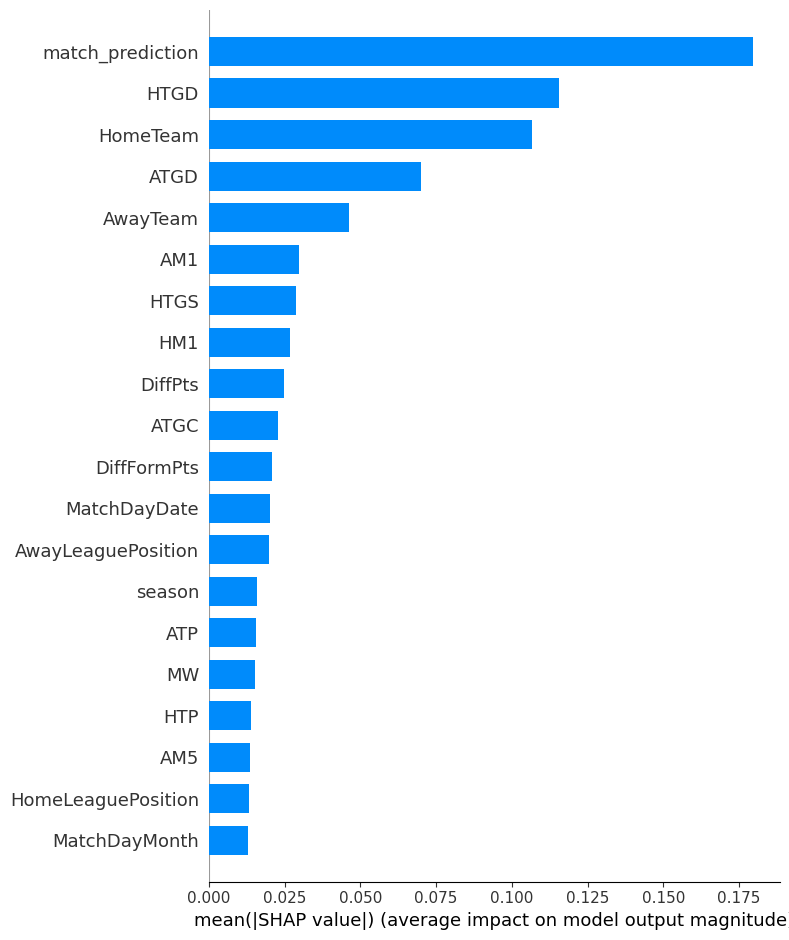

In [31]:
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_1.feature_names_],
        plot_type = 'bar'
)

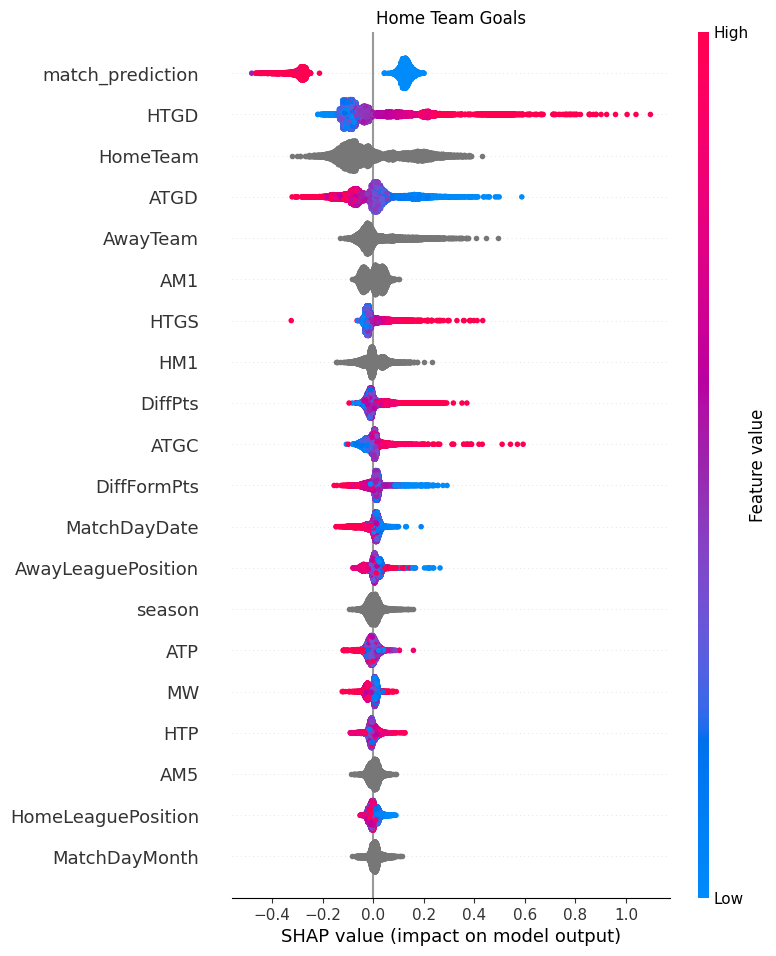

In [32]:
# Loop through each class and create a summary plot
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_1.feature_names_], 
        show=False
)
plt.title('Home Team Goals')
plt.show()

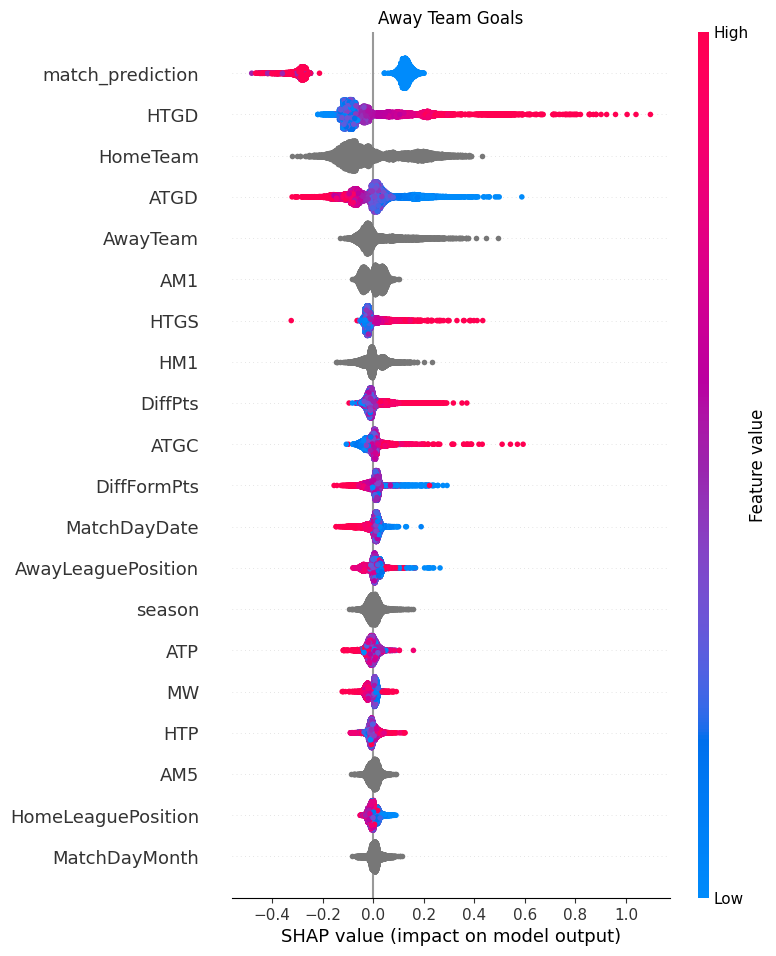

In [33]:
# Loop through each class and create a summary plot
shap.summary_plot(
        shap_values, 
        transformed_data[regressor_2.feature_names_], 
        show=False
)
plt.title('Away Team Goals')
plt.show()

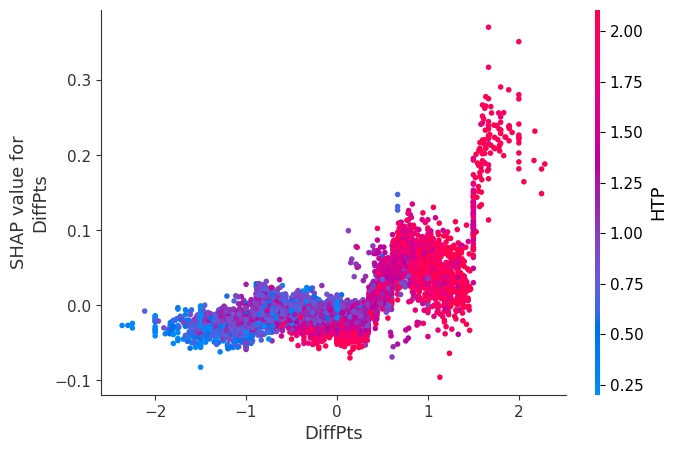

In [34]:
shap.dependence_plot(
    'DiffPts', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)

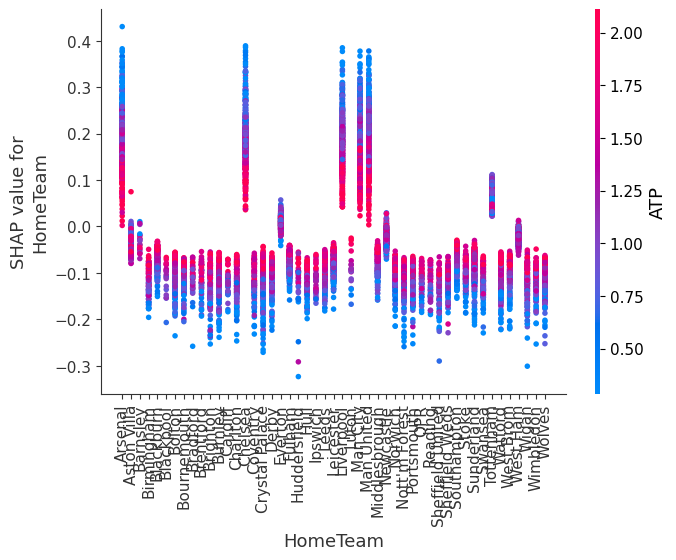

In [35]:
shap.dependence_plot(
    'HomeTeam', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)

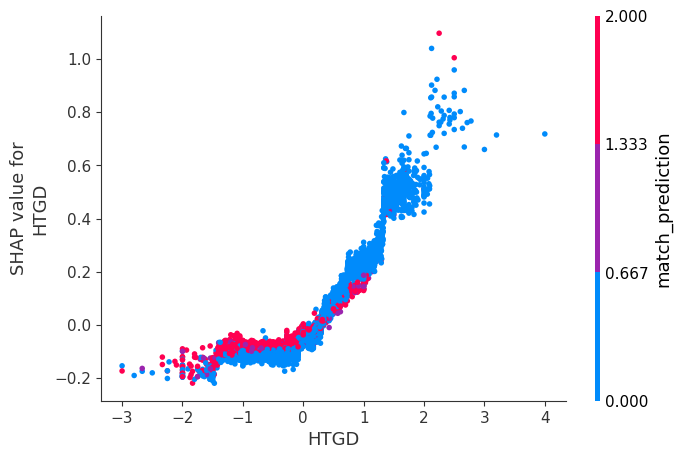

In [36]:
shap.dependence_plot(
    'HTGD', 
    shap_values, 
    transformed_data[regressor_1.feature_names_]
)